This notebook serves as a reproduction and introduction to the paper:  

@article{calvano2020artificial,  
  title = {**Artificial Intelligence, Algorithmic Pricing, and Collusion**},  
  author = {Calvano, Emilio and Calzolari, Giacomo and Denicolo, Vincenzo and Pastorello, Sergio},  
  year = {2020},  
  journal = {**American Economic Review**},  
  volume = {110},  
  number = {10},  
  pages = {3267--3297},  
  publisher = {{American Economic Association 2014 Broadway, Suite 305, Nashville, TN 37203}}  
  }

In [1]:
import numpy as np
np.random.seed(93)
import matplotlib.pyplot as plt

In this paper there are first paper that 
The original paper doesn't provide any mathematical proof of the collusion scenario.

*In fact*

# Part 1: The Model Setting

Assume there are $n$ different firms, the demand for firm $i$ at time $t$ is:
$$
    q_{i,t}=\frac{e^{\frac{a_i-p_{i,t}}\mu}}{\sum_{j=1}^ne^{\frac{a_j-p_{j,\iota}}\mu}+e^{\frac{a_0}\mu}}，
$$
where $p_{i,t}$ is the price of firm $i$ at time $t$, $a_i$ is the vertical differentiation, $\mu$ is an index of horizontal differentiation, and $a_0$ is an inverse index of aggregate demand. 

We further assume the per-period reward (profit) for each firm is given by:

$$
\pi_{i,t}=(p_{i,t} - c_i)\cdot q_{i,t},
$$

where $c_i$ is the unit cost for firm $i$. 

In this reproduction experiment, we only consider circumstance where $n=2$, which is a duopoly market.

For each agent (firm), we can compute its Bertrand-Nash equilibrium (one-shot game) $p^N$ and the monopoly price $p^M$. Then, taking the interval $[p^N-\xi(p^M-p^N), p^M+\xi(p^M-p^N)], \xi>0$, and splitting the interval into $m$ discrete prices, we can get the action space for each agent.

In [2]:
class Calvano1_env():

    def __init__(self, agent1_info, agent2_info, other_info):
        """
        All input parameters should be dictionaries.
        agent_info should contain keys: 'a', 'alpha', 'beta', 'c', 'delta'
        other_info should contain keys: 'a0', 'mu', 'm', 'k', 'xi'
        """
        self.agent1_info = agent1_info
        self.agent2_info = agent2_info
        self.other_info = other_info
        self.rewards_log = []
        self.actions_log = []
        self.prices_log = []
        self.action_spaces = None
        self.nash = None
        self.collusion = None
        self.Delta = None
        self.delta = None
        self.check()
        self.initialize()
    
    def check(self):
        agent_key = ['a', 'alpha', 'beta', 'c', 'delta']
        other_key = ['a0', 'mu', 'm', 'k', 'xi']
        if not all(key in self.agent1_info for key in agent_key):
            raise ValueError("Incorrect Parameters")
        if not all(key in self.agent2_info for key in agent_key):
            raise ValueError("Incorrect Parameters")
        if not all(key in self.other_info for key in other_key):
            raise ValueError("Incorrect Parameters")
        
    def step(self, actions):
        self.actions_log.append(actions)
        prices = self.action_spaces[0][actions[0]], self.action_spaces[1][actions[1]]
        self.prices_log.append(prices)
        rewards = self.execute(prices)
        self.rewards_log.append(rewards)
        k = self.other_info['k']
        if k == 0:
            states = (0, 0)
        elif k == 1:
            states = (k*actions[0] + actions[1], k*actions[1] + actions[0])
        else:
            raise ValueError("k should be whether 0 or 1.")
        converge = self.converge()
        return states, rewards, converge
    
    def execute(self, actions):
        a0, mu = self.other_info['a0'], self.other_info['mu']
        a1, a2 = self.agent1_info['a'], self.agent2_info['a']
        base = np.exp(a0 / mu)
        demands = np.exp((np.array([a1, a2]) - np.array(actions)) / mu)
        demands = demands / (demands.sum() + base)
        costs = np.array([self.agent1_info['c'], self.agent2_info['c']])
        rewards = demands * (actions - costs)
        return rewards
    
    def initialize(self, lower = 1, upper = 2.5, space = 0.01):
        """
        Compute the nash, collusion prices and the actions spaces.
        """
        prices = np.arange(lower, upper, space)
        matrix = np.empty((len(prices), len(prices), 2))
        for i, p1 in enumerate(prices):
            for j, p2 in enumerate(prices):
                matrix[i, j] = self.execute((p1, p2))
        max_agent1 = np.argmax(matrix[:, :, 0], axis=0)
        dominant1 = list(zip(max_agent1, range(len(prices))))
        max_agent2 = np.argmax(matrix[:, :, 1], axis=1)
        dominant2 = list(zip(range(len(prices)), max_agent2))
        nash = [x for x in dominant1 if x in dominant2]
        if len(nash) == 0:
            raise ValueError('There is no Nash-equilibrium.')
        elif len(nash) > 1:
            print("There are multiple Nash-equilibriums, picked the first one.")
        nash = nash[0]
        self.nash = np.array((prices[nash[0]], prices[nash[1]]))
        print(f"The nash equilibrium prices are {self.nash[0]}, {self.nash[1]}")
        matrix = np.sum(matrix, axis=2)
        collusion = np.unravel_index(np.argmax(matrix), matrix.shape)
        self.collusion = np.array((prices[collusion[0]], prices[collusion[1]]))
        print(f"The collusion prices are {self.collusion[0]}, {self.collusion[1]}")
        lower = self.nash - self.other_info['xi'] * (self.collusion - self.nash)
        upper = self.collusion - self.other_info['xi'] * (self.collusion - self.nash)
        self.action_spaces = [np.linspace(lower[0], upper[0], self.other_info['m']), 
                            np.linspace(lower[1], upper[1], self.other_info['m'])]
    
    def converge(self):
        if len(self.actions_log) < 1000:
            return False
        else:
            if len(set(self.actions_log[-1000:])) == 1:
                return True
            else:
                return False
    
    def cal_Delta(self):
        nash = np.sum(self.execute(self.nash))
        collusion = np.sum(self.execute(self.collusion))
        profits = np.sum(self.rewards_log, axis=1)
        cum_profits = np.cumsum(profits) / np.arange(1, len(profits) + 1)
        delta = (profits - nash) / (collusion - nash)
        Delta = (cum_profits - nash) / (collusion - nash)
        self.delta = delta
        self.Delta = Delta

    def plot(self):
        self.cal_Delta()
        Delta, delta = self.Delta, self.delta
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))

        ax1.plot(np.arange(1, len(Delta) + 1), Delta, label='Dynamics', color='aqua', linewidth=0.8)
        ax1.axhline(y=0, color='violet', linestyle='--', linewidth=1, label='Nash')
        ax1.axhline(y=1, color='crimson', linestyle='--', linewidth=1, label='Collusion')
        ax1.set_title('Cummulative Delta')
        ax1.set_xlabel('t')
        ax1.set_ylabel('Delta')

        ax2.plot(np.arange(1, len(delta) + 1), delta, label='Dynamics', color='aqua', linewidth=0.08)
        ax2.axhline(y=0, color='violet', linestyle='--', linewidth=1, label='Nash')
        ax2.axhline(y=1, color='crimson', linestyle='--', linewidth=1, label='Collusion')
        ax2.set_title('Instantaneous Delta')
        ax2.set_xlabel('t')
        ax2.set_ylabel('Delta')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

Now we discuss the state space for each agent. The state is given by:

$$
s_t = \{\bold{p}_{t-1},\cdots,\bold{p}_{t-k}\}.
$$

The vector $\bold{p}_{t}$ denotes the prices of all agents at time $t$, which means the agent can utilize the competitors' pricing information.

The authors only consider cases under $k=1$ or $k=0$, to reduce the complexity of the trainning step. The authors illustarte that:

 "*while the assumption of a one-period memory is restrictive, it might have a limited impact on the sustainability of collusion, because the richness of the state space may substitute for the length of the memory*".

 In the paper, the agents use Q-learning algorithm with exploration to make decision. Each agent agent maintain a Q-matrix $Q(s, a)$ with the size $|A|\cdot|S|=m\cdot m^{nk}$. At each period $t$, the agent make decision by maximizing the expected Q-value (with exploration) given the current state $s$, then recieve a reward $\pi_t$ and the new state $s^\prime$. After that, the agent update one element of its Q-matrix:
 
 $$
 Q_{t+1}(s,a)~=~(1-\alpha)Q_t(s,a)+\alpha\Big[\pi_t+\delta\max_{a\in A}Q_t(s^{\prime},a)\Big].
 $$

Where $\alpha$ is the **learning rate** and $\delta$ is the discounted factor. 

In the model setting, the agent makes decision with $\epsilon$-greedy strategy, which means at time $t$ the agent have probability $\epsilon_t$ to choose randomly, otherwise make decision greedly by choosing $\argmax_a Q(s, a)$. $\epsilon_t$ is expressed by:

$$
\epsilon_t = e^{-\beta t},
$$

where $\beta$ is the parameter to adjust the exploration diminishing rate, and I call it the **exploration rate**.

In the baseline model setting, the agent initialize its Q-matrix by:

$$
Q_{i,0}(s,a_i)~=~\frac{\sum_{a_{-i}\in A^{n-1}}\pi_i(a_i,a_{-i})}{(1-\delta)|A|^{n-1}}.
$$







In [3]:
class Calvano1_agent:
    def __init__(self, agent_info, other_info, env):
        self.t = 0
        self.last_action = None
        self.info = agent_info
        self.state_dim = other_info['m'] ** (other_info['k']*2)
        self.action_dim = other_info['m']
        self.state = np.random.choice(np.arange(self.state_dim)) # the initial state is randomly the same as in the paper
        self.Q = np.random.random((self.state_dim, self.action_dim))
        self.initialize_Q(env)

    def initialize_Q(self, env):
        for action in np.arange(self.action_dim):
            sum = np.sum([env.execute((action, comp))[0] for comp in np.arange(self.action_dim)])
            Q = sum / ((1-self.info['delta']) * self.action_dim)
            self.Q[:, action] = Q

    def action(self):
        epsilon = np.exp(-self.info['beta'] * self.t)
        if np.random.random() < epsilon:
            action = np.random.choice(np.arange(self.action_dim))
        else:
            action = np.argmax(self.Q[self.state, :])
        self.last_action = action
        return action

    def update(self, new_state, reward):
        self.t += 1
        self.Q[self.state, self.last_action] = (1-self.info['alpha']) * self.Q[self.state, self.last_action] + self.info['alpha'] * (reward + self.info['delta']*np.max(self.Q[new_state, :])) 
        self.state = new_state
        

Now we've write the classes need to build the enviroment and the agents. Here I breifly introcude the logic of the code.

The first class `Calvano1_env` is buit to:

1. calculate some meta-information of the system, such as:
    - the prices under the Nash-equilibrium `self.nash`;
    - the prices under the collusion `self.collusion`;
    - and the action_space `self.action_spaces` for each agent;
2. provide the enviroment for the two agents to interact with, such as calculating the profits (rewards) given the prices (actions):
    -  `self.execute(prices)` to calculate the profits given `prices`;
    -  `self.step(actions)`: similar to `gym.env.step()`, privding the rewards and new states and whether the game has convergd.
    - **attention**: *actions* and *prices* are not the same.  *action* is an abstraction of *price* that the agent can recgonise. 
    `self.step(actions)` can transform  *actions* to *prices*, and the latter one can be used by `self.execute()` to compute the rewards.
3. document and visualize the trace of the system, such as `self.rewards_log`.

The second class `Calvano1_agent` is built to conduct Q-learning. The `action()` method can make decision given the current state, and the `update` method can update the Q-matrix.

To use the two classes to run numerical experiments, one need to provide three informations, all of which are using the dictionary format:

1. the information of the first agent: `agent1_info`;
2. the information of the second agent: `agent2_info`;
3. some mutual information: `other_info`.

In [4]:
alpha, beta = 0.025, 1e-5
agent1_info = {'a': 2, 'c': 1, 'alpha': alpha, 'beta': beta, 'delta': 0.95}
agent2_info = {'a': 2, 'c': 1, 'alpha': alpha, 'beta': beta, 'delta': 0.95}
other_info = {'a0': 0, 'mu': 0.25, 'm': 15, 'k': 1, 'xi':0.1}

Now, we can buid instances of the environment and agent. **Remember**, always build the instance `Calvano1_env` first, because the initialization of instance `Calvano1_agent` needs the method of the environment.

When initialization an instance `Calvano1_env`, the nash equilibrium prices and the collusion prices would be printed.

In [5]:
env = Calvano1_env(agent1_info, agent2_info, other_info)
agent1 = Calvano1_agent(agent1_info, other_info, env)
agent2 = Calvano1_agent(agent2_info, other_info, env)

There are multiple Nash-equilibriums, picked the first one.
The nash equilibrium prices are 1.4700000000000004, 1.4700000000000004
The collusion prices are 1.9200000000000008, 1.9200000000000008


Here we privde an example to run 10000 periods. After that, we can use `env.plot()` to plot the system dynamics of the past periods.

In the paper, the authors utilize $\Delta$ (*average profit gain*) to measure the dynamics of the game:
$$
\Delta\equiv\frac{\bar{\pi}-\pi^N}{\pi^M-\pi^N},
$$

where $\bar{\pi}$ is the averageper-firm profit upon convergence. Thus, $\Delta=0$ corresponds to the competitive outcome and $\Delta=1$ to the perfectly collusive outcome.

After running the system, we can use `env.plot()` to plot the system dynamics of the past periods.

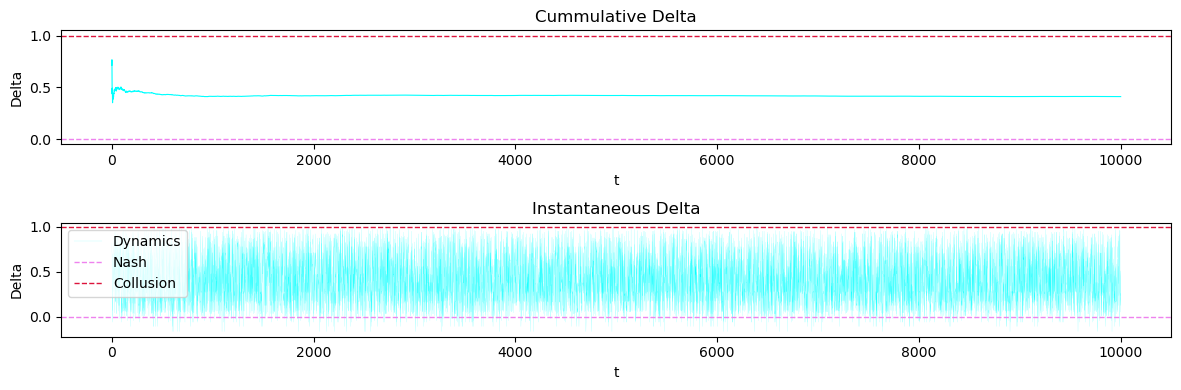

In [6]:
for _ in range(10000):
    actions = agent1.action(), agent2.action()
    states, rewards, converge = env.step(actions)
    agent1.update(states[0], rewards[0])
    agent1.update(states[1], rewards[1])
env.plot()


# Part 2: The Baseline Experiment

In the baseline experiment, 

In [7]:
Alpha = np.linspace(0.025, 0.25, 20)
Beta = np.linspace(1e-7, 2e-5, 20)
matrix_nash = np.empty((100, 100))
matrix_delta = np.empty((100, 100))
for ia, alpha in enumerate(Alpha):
    for ib, beta in enumerate(Beta):
        Delta, Nash = 0, 0
        for _ in range(20):
            agent1_info = {'a': 2, 'c': 1, 'alpha': alpha, 'beta': beta, 'delta': 0.95}
            agent2_info = {'a': 2, 'c': 1, 'alpha': alpha, 'beta': beta, 'delta': 0.95}
            other_info = {'a0': 0, 'mu': 0.25, 'm': 15, 'k': 1, 'xi':0.1}
            env = Calvano1_env(agent1_info, agent2_info, other_info)
            agent1 = Calvano1_agent(agent1_info, other_info, env)
            agent2 = Calvano1_agent(agent2_info, other_info, env)
            iter = 0
            while iter <= 1000000:
                actions = agent1.action(), agent2.action()
                states, rewards, converge = env.step(actions)
                agent1.update(states[0], rewards[0])
                agent1.update(states[1], rewards[1])
                if converge:
                    break
                iter += 1
            price = env.prices_log[-1]
            if np.all(price == env.nash):
                Nash += 1
            nash = np.sum(env.execute(env.nash))
            collusion = np.sum(env.execute(env.collusion))
            profits = np.sum(env.rewards_log[-1])
            delta = (profits - nash) / (collusion - nash)
            Delta += delta
        matrix_nash[ia, ib] = Nash / 20
        matrix_delta[ia, ib] = Delta / 20

There are multiple Nash-equilibriums, picked the first one.
The nash equilibrium prices are 1.4700000000000004, 1.4700000000000004
The collusion prices are 1.9200000000000008, 1.9200000000000008
There are multiple Nash-equilibriums, picked the first one.
The nash equilibrium prices are 1.4700000000000004, 1.4700000000000004
The collusion prices are 1.9200000000000008, 1.9200000000000008
There are multiple Nash-equilibriums, picked the first one.
The nash equilibrium prices are 1.4700000000000004, 1.4700000000000004
The collusion prices are 1.9200000000000008, 1.9200000000000008
There are multiple Nash-equilibriums, picked the first one.
The nash equilibrium prices are 1.4700000000000004, 1.4700000000000004
The collusion prices are 1.9200000000000008, 1.9200000000000008
There are multiple Nash-equilibriums, picked the first one.
The nash equilibrium prices are 1.4700000000000004, 1.4700000000000004
The collusion prices are 1.9200000000000008, 1.9200000000000008
There are multiple Nash-e

KeyboardInterrupt: 

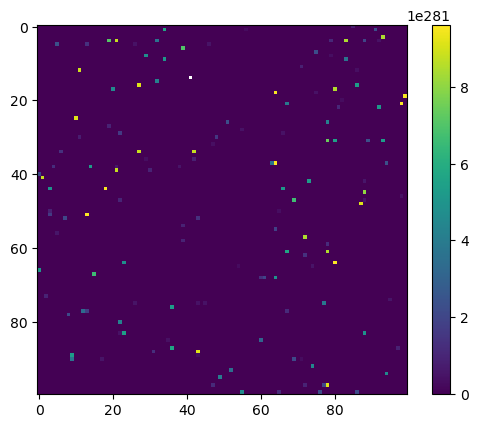

c:\Users\Tang Chen\anaconda3\envs\RL\lib\site-packages\matplotlib\image.py:463: RuntimeWarning: overflow encountered in scalar multiply
  newmin = vmid - dv * fact
c:\Users\Tang Chen\anaconda3\envs\RL\lib\site-packages\matplotlib\image.py:468: RuntimeWarning: overflow encountered in scalar multiply
  newmax = vmid + dv * fact


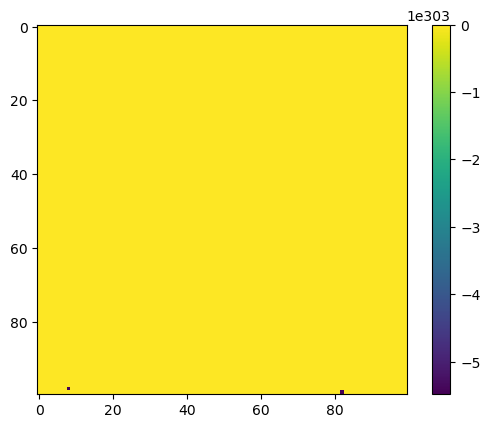

In [ ]:
plt.imshow(matrix_nash, cmap='viridis')  
plt.colorbar() 
plt.show()

plt.imshow(matrix_delta, cmap='viridis')  
plt.colorbar() 
plt.show()

# Part 3: the Rest of the Paper